In [5]:
import logging
import pandas as pd
from sklearn.linear_model import LinearRegression
import wandb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os,sys,yaml
import requests

module_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

if module_path not in sys.path:
    sys.path.append(module_path)
# Now you can import your module
from src.DataOps.feature_engg import feature_engg_class
from src.ModelOps.model_fit import ModelFit
from src.DataOps.feature_engg import feature_engg_class
import numpy as np
import logging
import requests
import json
from tqdm import tqdm
logging.basicConfig(level=logging.INFO)

In [4]:
#load NASA_API_KEY from .env file
import os
from dotenv import load_dotenv
load_dotenv()
ALPHA_VANTAGE_API_KEY=os.getenv("ALPHA_VANTAGE_API_KEY")

In [56]:
import requests
import json
from tqdm import tqdm


def request_stock_price_hist(symbol, token, sample = False):
    if sample == False:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&outputsize=full&apikey={}'
    else:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 6))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Weekly Adjusted Time Series'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Weekly Adjusted Time Series'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount"]
    df['date'] = date
    df = df.set_index('date')
    df = df.sort_index(ascending=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


In [57]:
data=request_stock_price_hist('IBM', ALPHA_VANTAGE_API_KEY)

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 1279/1279 [00:01<00:00, 688.97it/s]


In [58]:
#convert all columns to numeric
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1279 entries, 1999-11-12 to 2024-05-06
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1279 non-null   float64
 1   high             1279 non-null   float64
 2   low              1279 non-null   float64
 3   close            1279 non-null   float64
 4   adjusted close   1279 non-null   float64
 5   volume           1279 non-null   int64  
 6   dividend amount  1279 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 79.9+ KB


<Axes: xlabel='date'>

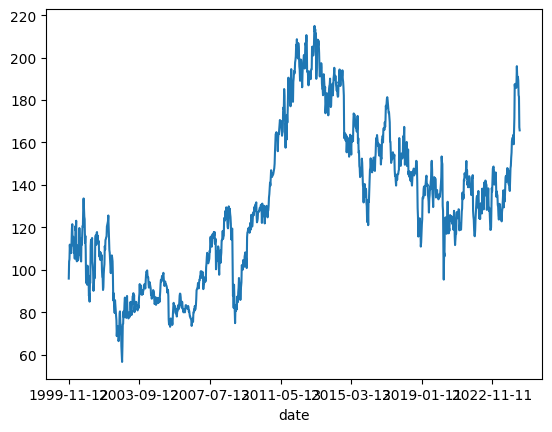

In [124]:
 #plot the close column 
data['close'].plot()

### Train- Test Split


In [10]:
logging.info("Data loaded successfully")
df=data[['close']].copy()
#overall shape of the data
df.shape

INFO:root:Data loaded successfully


(1279, 1)

In [11]:
#print out the first and the last index
df.index[0], df.index[-1]

('1999-11-12', '2024-05-06')

### Prophet

In [12]:
!pip install prophet


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [13]:
from prophet import Prophet

In [14]:
df_prophet=data.copy().copy()
df_prophet.reset_index(inplace=True)
df_prophet['date']=pd.to_datetime(df_prophet['date'])
df_prophet.columns

Index(['date', 'open', 'high', 'low', 'close', 'adjusted close', 'volume',
       'dividend amount'],
      dtype='object')

In [15]:
df_prophet=df_prophet[['date','close']]
df_prophet.columns = ['ds','y']
df_prophet.head()

,ds,y
0,1999-11-12,95.87
1,1999-11-19,103.94
2,1999-11-26,105.00
3,1999-12-03,111.87
4,1999-12-10,109.00


In [16]:
train=df_prophet[:int(0.7*df_prophet.shape[0])]
test=df_prophet[int(0.7*df_prophet.shape[0]):]

In [36]:
test.tail()

,ds,y
1274,2024-04-12,182.27
1275,2024-04-19,181.58
1276,2024-04-26,167.13
1277,2024-05-03,165.71
1278,2024-05-06,168.61


Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [43]:
model = Prophet()
model.add_country_holidays(country_name='US')
model.fit(train)
close_prices = model.make_future_dataframe(30)
forecast = model.predict(close_prices)
forecast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DEBUG:cmdstanpy:input tempfile: /var/folders/q4/vwc0394j1k7cy5ls55tg9jw00000gp/T/tmp__5yedj7/xhlmt99e.json
DEBUG:cmdstanpy:input tempfile: /var/folders/q4/vwc0394j1k7cy5ls55tg9jw00000gp/T/tmp__5yedj7/8hb69mz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/sakshamgulati/.local/share/virtualenvs/MLOps_Template-k_6XISXV/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13157', 'data', 'file=/var/folders/q4/vwc0394j1k7cy5ls55tg9jw00000gp/T/tmp__5yedj7/xhlmt99e.json', 'init=/var/folders/q4/vwc0394j1k7cy5ls55tg9jw00000gp/T/tmp__5yedj7/8hb69mz5.json', 'output', 'file=/var/folders/q4/vwc0394j1k7cy5ls55tg9jw00000gp/T/tmp__5yedj7/prophet_modelgto615u2/prophet_model-20240506223605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO

In [48]:
train.tail()

,ds,y
890,2016-12-02,160.02
891,2016-12-09,166.52
892,2016-12-16,166.73
893,2016-12-23,166.71
894,2016-12-30,165.99


In [54]:
merged_df=pd.merge(test, forecast, on='ds', how='inner')
merged_df

,ds,y,yhat,yhat_lower,yhat_upper
0,2017-01-06,169.53,138.912705,124.895441,151.602547
1,2017-01-13,167.34,138.666492,125.011408,151.728264
2,2017-01-20,170.55,138.322230,123.720082,152.274209
3,2017-01-27,177.30,138.132261,124.118721,151.623788


/Users/sakshamgulati/.local/share/virtualenvs/MLOps_Template-k_6XISXV/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/sakshamgulati/.local/share/virtualenvs/MLOps_Template-k_6XISXV/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


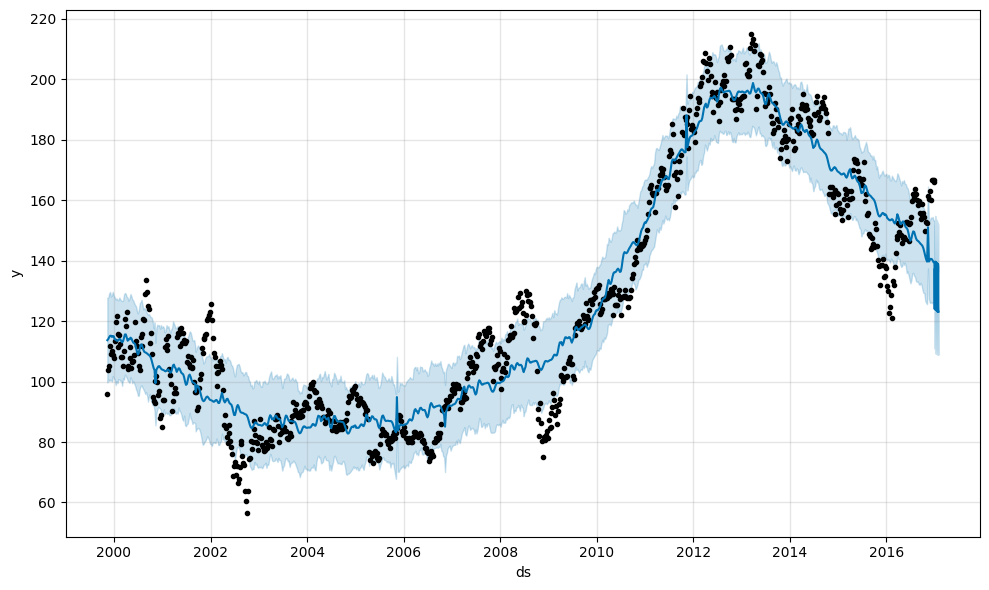

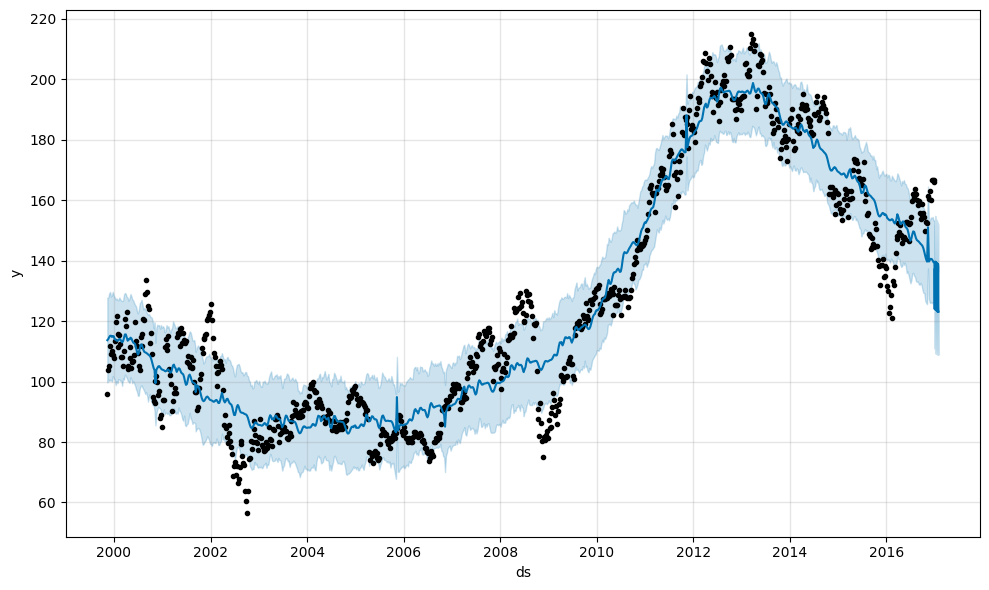

In [33]:
#plot forecast and actual prices
model.plot(forecast)

In [53]:
## RMSE
rms=np.sqrt(np.mean(np.power((np.array(merged_df['y'])-np.array(merged_df['yhat_upper'])),2)))
rms

19.73823880097635

In [149]:
from prophet.serialize import model_to_json, model_from_json
output_dir='artifacts/prophet_model'
#concatenate output directory with the model name to create a path
model_path = os.path.join(output_dir, 'serialized_model.json')
os.makedirs(output_dir, exist_ok=True)
with open(model_path, 'w') as fout:
    fout.write(model_to_json(model))  # Save model

In [ ]:
import requests
import json
from tqdm import tqdm


def request_stock_price_hist(symbol, token):
    
    q_string = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={}&apikey={}'
    
    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 6))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Weekly Adjusted Time Series'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Weekly Adjusted Time Series'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount"]
    df['date'] = date
    df = df.set_index('date')
    df = df.sort_index(ascending=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


### Inference starting